# Exploratory Data Analysis

## Start Spark Session

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Bosch Project").getOrCreate()

In [4]:
spark

## Load feature datasets

In [5]:
# Load train_numeric dataset
num = spark.read\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .format('csv')\
  .load('s3://jiaruxu233/train_numeric.csv')

In [8]:
# Load train_categorical
cat = spark.read\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .format('csv')\
  .load('s3://jiaruxu233/train_categorical.csv')

In [7]:
# Load train_date
date = spark.read\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .format('csv')\
  .load('s3://jiaruxu233/train_date.csv')

### Look into the structure of our features

In [11]:
# num.printSchema()
# Top several lines
# root
#  |-- Id: integer (nullable = true)
#  |-- L0_S0_F0: double (nullable = true)
#  |-- L0_S0_F2: double (nullable = true)
#  |-- L0_S0_F4: double (nullable = true)
#  |-- L0_S0_F6: double (nullable = true)
#  |-- L0_S0_F8: double (nullable = true)
#  |-- L0_S0_F10: double (nullable = true)
#  |-- L0_S0_F12: double (nullable = true)
#  |-- L0_S0_F14: double (nullable = true)

In [12]:
# cat.printSchema()
# Top several lines
# root
# |-- Id: integer (nullable = true)
# |-- L0_S1_F25: string (nullable = true)
# |-- L0_S1_F27: string (nullable = true)
# |-- L0_S1_F29: string (nullable = true)
# |-- L0_S1_F31: string (nullable = true)
# |-- L0_S2_F33: string (nullable = true)
# |-- L0_S2_F35: string (nullable = true)
# |-- L0_S2_F37: string (nullable = true)

In [13]:
# date.printSchema()
# cat.printSchema()
# Top several lines
# root
# |-- Id: integer (nullable = true)
# |-- L0_S0_D1: double (nullable = true)
# |-- L0_S0_D3: double (nullable = true)
# |-- L0_S0_D5: double (nullable = true)
# |-- L0_S0_D7: double (nullable = true)
# |-- L0_S0_D9: double (nullable = true)
# |-- L0_S0_D11: double (nullable = true)
# |-- L0_S0_D13: double (nullable = true)
# |-- L0_S0_D15: double (nullable = true)

## Explore the data size and failure rate

In [14]:
# First, create SQL table for three training data
dfnum = num.createOrReplaceTempView("dfnum")
dfcat = cat.createOrReplaceTempView("dfcat")
dfdate = date.createOrReplaceTempView("dfdate")

### Data size

In [11]:
# Check the size of dfnum
print("The number of rows in dfnum:" , spark.sql("SELECT * FROM dfnum").count())
print("The number of culomns in dfnum:" , len(num.columns))

# Check the size of dfcat
print("The number of rows in dfcat:" , spark.sql("SELECT * FROM dfcat").count())
print("The number of culomns in dfcat:" , len(cat.columns))

# Check the size of dfdate
print("The number of rows in dfdate:" , spark.sql("SELECT * FROM dfdate").count())
print("The number of culomns in dfdate:" , len(date.columns))

The number of rows in dfnum: 1183747
The number of culomns in dfnum: 970
The number of rows in dfcat: 1183747
The number of culomns in dfcat: 2141
The number of rows in dfdate: 1183747
The number of culomns in dfdate: 1157


From results above, we notice that our training dataset not only has a lot of records, but also has thousands of columns which may leads to ***the curse of dimensionality*** here if we are going to throw all these features into our model. Therefore, as for the next step, we are going to take a deeper look into those features and do a thoughtful feature selection in order to pick up those features that are indeed helpful.

### Missing values

In [104]:
import pyspark.sql.functions as F
num_na_count = num.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in num.columns])

In [102]:
df_num_na_count = num_na_count.toPandas().set_index("Id").transpose().reset_index()
df_num_na_count.columns = ['feature','count']
plotdf = df_num_na_count.groupby('count').count().reset_index()
plotdf.columns = ['na_count','fe_count']

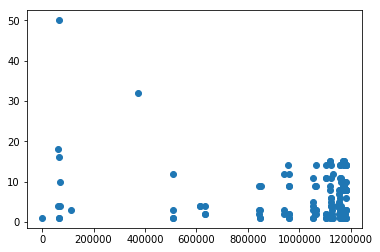

In [103]:
import matplotlib.pyplot as plt
x = plotdf['na_count']
y = plotdf['fe_count']
plt.scatter(x,y)
plt.show()

From plot above, we notive that a lot of columns has more than ***one million*** missing values which may not be quite helpful for our prediction.   

In [105]:
cat_na_count = cat.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in cat.columns])
df_cat_na_count = cat_na_count.toPandas().set_index("Id").transpose().reset_index()
df_cat_na_count.columns = ['feature','count']
plotdf = df_cat_na_count.groupby('count').count().reset_index()
plotdf.columns = ['na_count','fe_count']

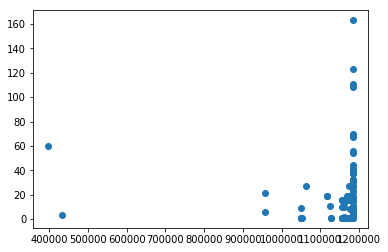

In [106]:
import matplotlib.pyplot as plt
x = plotdf['na_count']
y = plotdf['fe_count']
plt.scatter(x,y)
plt.show()

From plot above, we notice only two categorical features have missing values less than ***900k***.

In [107]:
date_na_count = date.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in date.columns])
df_date_na_count = date_na_count.toPandas().set_index("Id").transpose().reset_index()
df_date_na_count.columns = ['feature','count']
plotdf = df_date_na_count.groupby('count').count().reset_index()
plotdf.columns = ['na_count','fe_count']

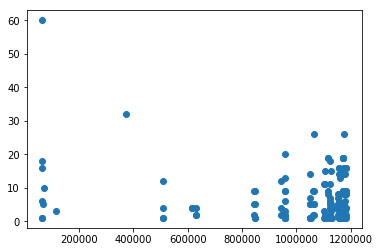

In [108]:
import matplotlib.pyplot as plt
x = plotdf['na_count']
y = plotdf['fe_count']
plt.scatter(x,y)
plt.show()

From plot above, we can conclude that with less missing features, date features may provide a better predictability in our model.

In conclusion, according to our previous findings, we notice that most features are missing here in our training dataset, especially ***categorical features***. Predictions may differ greatly depending on what features we are going to use and how we manage these missing values.

### Structure inside date features

In [15]:
import pandas as pd
import numpy as np
pddate = pd.read_csv('s3://jiaruxu233/train_date.csv', nrows=10000)

In [113]:
# Let's see some rows and columns in dfdate
spark.sql("SELECT Id,L0_S0_D1, L0_S0_D3, L0_S0_D5, L0_S0_D7,L0_S0_D9 FROM dfdate").show(10)

+---+--------+--------+--------+--------+--------+
| Id|L0_S0_D1|L0_S0_D3|L0_S0_D5|L0_S0_D7|L0_S0_D9|
+---+--------+--------+--------+--------+--------+
|  4|   82.24|   82.24|   82.24|   82.24|   82.24|
|  6|    null|    null|    null|    null|    null|
|  7|  1618.7|  1618.7|  1618.7|  1618.7|  1618.7|
|  9|  1149.2|  1149.2|  1149.2|  1149.2|  1149.2|
| 11|  602.64|  602.64|  602.64|  602.64|  602.64|
| 13| 1331.66| 1331.66| 1331.66| 1331.66| 1331.66|
| 14|    null|    null|    null|    null|    null|
| 16|    null|    null|    null|    null|    null|
| 18|  517.64|  517.64|  517.64|  517.64|  517.64|
| 23|    null|    null|    null|    null|    null|
+---+--------+--------+--------+--------+--------+
only showing top 10 rows



In [126]:
# Let's check the min and max times for each station
def get_station_times(dates, withId=False):
    times = []
    cols = list(dates.columns)
    if 'Id' in cols:
        cols.remove('Id')
    for feature_name in cols:
        if withId:
            df = dates[['Id', feature_name]].copy()
            df.columns = ['Id', 'time']
        else:
            df = dates[[feature_name]].copy()
            df.columns = ['time']
        df['station'] = feature_name.split('_')[1][1:]
        df = df.dropna()
        times.append(df)
    return pd.concat(times)

station_times = get_station_times(pddate, withId=True).sort_values(by=['Id', 'station'])
print(station_times[:5])
print("Shape of Station time is :",station_times.shape)
min_station_times = station_times.groupby(['Id', 'station']).min()['time']
max_station_times = station_times.groupby(['Id', 'station']).max()['time']
print("Probabilities for every station to have the same values: ",np.mean(1. * (min_station_times == max_station_times)))

   Id   time station
0   4  82.24       0
0   4  82.24       0
0   4  82.24       0
0   4  82.24       0
0   4  82.24       0
Shape of Station time is : (2048541, 3)
Probabilities for every station to have the same values:  0.9821721580467314


Through previous observation, we notive that when remove missing values, ***observation times are almost always unique for station Id pair***. Therefore, we could save memory by reading only one time for each station and prevent duplicate reading.

In [128]:
# Let's check station times for train and test
date_cols = pddate.drop('Id', axis=1).count().reset_index().sort_values(by=0, ascending=False)
date_cols['station'] = date_cols['index'].apply(lambda s: s.split('_')[1])
date_cols = date_cols.drop_duplicates('station', keep='first')['index'].tolist()
print(date_cols) # selected features with distinct times

train_date = pd.read_csv('s3://jiaruxu233/train_date.csv', usecols=date_cols)
print(train_date.shape)
train_station_times = get_station_times(train_date, withId=False)
print(train_station_times.shape)
train_time_cnt = train_station_times.groupby('time').count()[['station']].reset_index()
train_time_cnt.columns = ['time', 'cnt']
print(train_time_cnt.shape)

test_date = pd.read_csv('s3://jiaruxu233/test_date.csv', usecols=date_cols)
print(test_date.shape)
test_station_times = get_station_times(test_date, withId=False)
print(test_station_times.shape)
test_time_cnt = test_station_times.groupby('time').count()[['station']].reset_index()
test_time_cnt.columns = ['time', 'cnt']
print(test_time_cnt.shape)

['L3_S37_D3949', 'L3_S30_D3541', 'L3_S29_D3428', 'L3_S34_D3877', 'L3_S33_D3870', 'L0_S0_D3', 'L0_S1_D30', 'L0_S8_D145', 'L3_S36_D3919', 'L3_S35_D3910', 'L0_S5_D115', 'L0_S3_D70', 'L0_S6_D120', 'L0_S7_D143', 'L0_S2_D54', 'L0_S4_D106', 'L0_S12_D333', 'L0_S20_D465', 'L0_S13_D355', 'L0_S10_D266', 'L0_S11_D284', 'L0_S9_D192', 'L2_S26_D3084', 'L1_S24_D1828', 'L0_S19_D457', 'L0_S17_D432', 'L0_S14_D380', 'L0_S15_D401', 'L0_S16_D428', 'L2_S27_D3156', 'L0_S18_D447', 'L0_S21_D469', 'L0_S23_D629', 'L0_S22_D608', 'L3_S41_D4021', 'L3_S40_D3981', 'L3_S45_D4129', 'L3_S48_D4203', 'L3_S47_D4155', 'L3_S39_D3974', 'L3_S51_D4255', 'L1_S25_D1887', 'L3_S31_D3848', 'L3_S43_D4097', 'L3_S49_D4208', 'L3_S50_D4254', 'L3_S44_D4122', 'L3_S38_D3953', 'L3_S32_D3852', 'L2_S28_D3234', 'L3_S46_D4135', 'L3_S42_D4057']
(1183747, 52)
(14302781, 2)
(101341, 2)
(1183748, 52)
(14308197, 2)
(101265, 2)


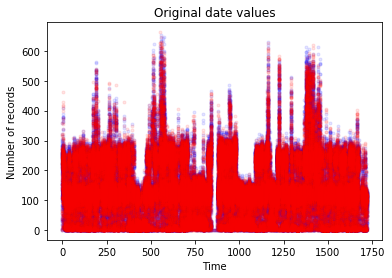

(0.0, 1718.48)
(0.0, 1718.49)


In [132]:
%matplotlib inline
fig = plt.figure()
plt.plot(train_time_cnt['time'].values, train_time_cnt['cnt'].values, 'b.', alpha=0.1, label='train')
plt.plot(test_time_cnt['time'].values, test_time_cnt['cnt'].values, 'r.', alpha=0.1, label='test')
plt.title('Original date values')
plt.ylabel('Number of records')
plt.xlabel('Time')
fig.savefig('original_date_values.png', dpi=300)
plt.show()

print((train_time_cnt['time'].min(), train_time_cnt['time'].max()))
print((test_time_cnt['time'].min(), test_time_cnt['time'].max()))

From result above, we can see two plots are highly overlapping. Therefore, dates are almost the same in train and test dataset.

### Number of stations and lines

In [20]:
def get_features(feature_list):
    # function to group features by station or line of production sinc the convention is:
    # L1_S15_F232 means Line 1, Station 15, Feature 232
    line_features = {}
    station_features = {}
    lines = set([item.split('_')[0] for item in feature_list])
    stations = set([item.split('_')[1] for item in feature_list])

    for l in lines:
        line_features[l] = [item for item in feature_list if '%s_' % l in item]

    for s in stations:
        station_features[s] = [item for item in feature_list if '%s_' % s in item]

    print ("The number of lines:", len(line_features))
    print ("The number of stations:", len(station_features))
    return (line_features, station_features)

feature_list = pd.DataFrame(num.head(1), columns=num.columns).drop(["Response", "Id"], axis=1).columns.values
features = get_features(feature_list)

The number of lines: 4
The number of stations: 50


We can find that:
* There are 4 lines and 50 stations in total. 
* Station 24, 25 has by far the most number of features, more than 200 feature per stations! at the same time most of the stations has less than 20 features. And worth noticing that station 32 has only one feature.

### Structure of target

Now, we'll take a look at the features or the columns and try to see how many station and line of production we have? how many features does each station have? how many products were processed in each station? and what's the failure rate per station?

In [133]:
spark.sql("SELECT Response, (Count(Response)/(Select Count(*) From dfnum))as rate FROM dfnum GROUP BY Response").collect()

[Row(Response=1, rate=0.00581120796927046),
 Row(Response=0, rate=0.9941887920307295)]

From rate above, we can see our target is ***highly imbalanced***. 'Response = 0' turns out to be a more frequent case than 'Response = 1' which quite makes sense because under most circumstances, quality control will work smoothly and will not bump into failures.

## Conclusion

From the results above we can say:

* We are dealing with more 1 million record per file.
* The number of columns per file is also large, 1000 to 2000 per file. Each column represents a feature the corresponds to some measurement on a station or a machine.
* Each file contains the "Id" column which represent the unique identifier of the product unit that we are tracking.
* Finally we notice that  average failure rate is about 0.58%, so it will be challenging to try to predict such small number from this huge data set and to not mess up with randomness.

In [138]:
spark.stop()